# CRAFT++ Framework Demo - Simulated Environment Workflow

This notebook demonstrates the complete CRAFT++ workflow with simulated environment, aligned with **Method.md** framework.

## Workflow Overview

1. **Setup** - Import modules and configure LLM API
2. **Data Generation** - Generate robot execution data in AI2THOR simulation
3. **Scene Graph Generation** - Build hierarchical scene representations (Method.md Section 1)
4. **Constraint Generation** - Generate logical constraints using LLM (Method.md Section 2)
5. **Constraint Code Generation** - Compile constraints to executable code/AST (Method.md Section 2.2)
6. **Failure Detection** - Validate constraints using executable logic (Method.md Section 4)
7. **Progressive Explanation** - Generate detailed failure analysis

## Alignment with Method.md

| Step | Method.md Section | Description |
|------|-------------------|-------------|
| Data Generation | - | Generate robot execution data in simulated environment |
| Scene Graph | Section 1 | Build hierarchical scene representations with objects, relationships, and states |
| Constraint Generation | Section 2 | LLM generates structured constraints (pre/post/invariants) |
| Constraint Compilation | Section 2.2 | Compile constraints to executable AST/DSL expressions |
| Failure Detection | Section 4 | Validate constraints using executable logic engine |
| Explanation | Section 5 | Generate progressive failure analysis with causal chains |

## Note on Environment Memory (Method.md Section 3)

In this simulated environment workflow, **Environment Memory** (Section 3) is simplified because:
- AI2THOR provides deterministic object states and positions
- No occlusion or sensor noise issues (unlike real-world scenarios)
- Object states are directly available from event metadata

For real-world applications, the Environment Memory module would:
- Apply Kalman/Bayesian filters for position smoothing
- Track `last_seen` timestamps and handle occlusion
- Maintain state confidence with decay models
- Predict object positions when occluded

The constraint validation (Step 6) still follows Method.md Section 4, using executable logic for deterministic failure detection.

In [1]:
import os
import sys
import json
from pathlib import Path

# IMPORTANT: Add parent directory to path BEFORE importing other modules
# When notebook is in /home/leo/craft, we need to add /home/leo to path
# This must be done before any craft imports
parent_dir = Path.cwd().parent
parent_dir_str = str(parent_dir)
if parent_dir_str not in sys.path:
    sys.path.insert(0, parent_dir_str)
    print(f"✅ 已添加父目录到路径: {parent_dir_str}")

# Debug: Show current paths
print(f"当前工作目录: {Path.cwd()}")
print(f"Python路径前3项: {sys.path[:3]}")

# Now import other modules
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML

# Import CRAFT modules
from craft.core import SceneGraph, Node, Edge, TaskExecutor
from craft.perception import ObjectDetector, SceneAnalyzer
from craft.reasoning import (
    LLMPrompter, FailureAnalyzer, 
    ConstraintGenerator, CausalVerifier, ConsistencyVerifier
)
from craft.correction import CorrectionPlanner
from craft.utils import load_config

print("✅ All modules imported successfully!")


✅ 已添加父目录到路径: /home/leo
当前工作目录: /home/leo/craft
Python路径前3项: ['/home/leo', '', '/home/leo/catkin_ws/devel/lib/python3/dist-packages']
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ All modules imported successfully!


In [2]:
# 使用poloapi配置（与reflect/demo.ipynb相同）
API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
POLOAPI_BASE_URL = "https://poloai.top/v1"  # poloapi 的接口地址

print(f"✅ API配置完成: {POLOAPI_BASE_URL}")


✅ API配置完成: https://poloai.top/v1


In [3]:
# 重新初始化LLM Prompter（使用poloapi配置，解决超时问题）
print("Re-initializing LLM Prompter with poloapi configuration...")

# 确保使用poloapi配置
if 'API_KEY' not in globals():
    API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
if 'POLOAPI_BASE_URL' not in globals():
    POLOAPI_BASE_URL = "https://poloai.top/v1"

llm_model = "gpt-3.5-turbo"

# 创建 LLMPrompter，使用poloapi配置
llm_prompter = LLMPrompter(
    gpt_version=llm_model,
    api_key=API_KEY,
    base_url=POLOAPI_BASE_URL  # 使用poloapi的base_url
)

print(f"✅ LLM Prompter re-initialized with {llm_model} via poloapi")
print(f"   Base URL: {POLOAPI_BASE_URL}")
print(f"   API Key: {API_KEY[:20]}...")


Re-initializing LLM Prompter with poloapi configuration...
✅ LLM Prompter re-initialized with gpt-3.5-turbo via poloapi
   Base URL: https://poloai.top/v1
   API Key: sk-wJJVkr6BUx8LruNeH...


## Complete Simulated Environment Workflow (CRAFT++ Framework)

This section demonstrates the complete CRAFT++ workflow with real AI2THOR execution:
1. Data Generation - Generate task execution data using AI2THOR
2. Video Display - Visualize task execution with annotations
3. Scene Graph Generation - Build hierarchical scene representations
4. Constraint Generation - Generate logical constraints using LLM
5. Constraint Code Generation - Compile to executable code (AST)
6. Code-based Failure Detection - Validate using executable logic
7. Progressive Explanation - Generate detailed failure analysis


In [4]:
# ============================================================================
# COMPLETE CRAFT++ WORKFLOW WITH REAL AI2THOR EXECUTION
# Based on Method.md framework and REFLECT demo example
# Uses real AI2THOR execution like REFLECT demo
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import json
import os
import time
import math

# Import CRAFT core modules
from craft.core import SceneGraph, Node, Edge, TaskExecutor
from craft.reasoning import (
    LLMPrompter, FailureAnalyzer, 
    ConstraintGenerator, CausalVerifier, ConsistencyVerifier
)
from craft.correction import CorrectionPlanner

# Import additional dependencies
try:
    import networkx as nx
except ImportError:
    import networkx as nx

try:
    import cv2
except ImportError:
    print("⚠️  cv2 not available, video generation may be limited")
    cv2 = None

# Import AI2THOR
try:
    from ai2thor.controller import Controller
    from ai2thor.platform import CloudRendering
    AI2THOR_AVAILABLE = True
except ImportError:
    print("⚠️  AI2THOR not installed. Install with: pip install ai2thor")
    AI2THOR_AVAILABLE = False
    Controller = None

# Define visualization function if not already defined
if 'visualize_scene_graph_fixed' not in globals():
    def visualize_scene_graph_fixed(scene_graph, title="Scene Graph"):
        """Create a visual representation of the scene graph (fixed version)"""
        G = nx.DiGraph()
        
        # Add nodes
        node_labels = {}
        for node in scene_graph.nodes:
            label = f"{node.get_name()}\n({node.object_type})"
            G.add_node(node.name, label=label, state=node.state)
            node_labels[node.name] = label
        
        # Add edges
        for (start_name, end_name), edge in scene_graph.edges.items():
            G.add_edge(start_name, end_name, label=edge.edge_type)
        
        # Create layout
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        # Draw the graph
        plt.figure(figsize=(14, 10))
        
        # Draw nodes - FIXED: handle None state properly
        node_colors = []
        for node in G.nodes():
            state = G.nodes[node].get('state') or ''  # Handle None state
            if state and 'empty' in state:
                node_colors.append('#FFE5B4')  # Light orange for empty objects
            elif state and 'closed' in state:
                node_colors.append('#E0E0E0')  # Gray for closed objects
            else:
                node_colors.append('#B0E0E6')  # Light blue for other objects
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              node_size=3000, alpha=0.9, node_shape='o')
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos, labels=node_labels, 
                              font_size=9, font_weight='bold')
        
        # Draw edges
        edge_labels = {}
        for (start, end), edge_data in G.edges.items():
            edge_labels[(start, end)] = edge_data.get('label', '')
        
        nx.draw_networkx_edges(G, pos, edge_color='gray', 
                             arrows=True, arrowsize=20, 
                             connectionstyle='arc3,rad=0.1', width=2)
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
        
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print detailed information
        print("\n" + "="*60)
        print("Scene Graph Details:")
        print("="*60)
        print(f"\nTotal Nodes: {len(G.nodes())}")
        print(f"Total Edges: {len(G.edges())}")
        print("\nNode Information:")
        for node in G.nodes():
            state = G.nodes[node].get('state') or 'N/A'
            print(f"  • {node}: state={state}")
        print("\nEdge Information:")
        for (start, end), edge_data in G.edges.items():
            rel_type = edge_data.get('label', 'unknown')
            print(f"  • {start} --[{rel_type}]--> {end}")

print("="*80)
print("COMPLETE CRAFT++ WORKFLOW")
print("="*80)
print("\nThis workflow demonstrates the complete CRAFT++ framework:")
print("1. Data Generation - Generate simulated task execution data")
print("2. Video Display - Visualize task execution with annotations")
print("3. Scene Graph Generation - Build hierarchical scene representations")
print("4. Constraint Generation - Generate logical constraints using LLM")
print("5. Constraint Code Generation - Compile to executable code (AST)")
print("6. Code-based Failure Detection - Validate using executable logic")
print("7. Progressive Explanation - Generate detailed failure analysis")
print("="*80)



COMPLETE CRAFT++ WORKFLOW

This workflow demonstrates the complete CRAFT++ framework:
1. Data Generation - Generate simulated task execution data
2. Video Display - Visualize task execution with annotations
3. Scene Graph Generation - Build hierarchical scene representations
4. Constraint Generation - Generate logical constraints using LLM
5. Constraint Code Generation - Compile to executable code (AST)
6. Code-based Failure Detection - Validate using executable logic
7. Progressive Explanation - Generate detailed failure analysis


### Step 1: Data Generation with Real AI2THOR Execution

This step executes the task in AI2THOR simulation environment, similar to REFLECT's approach:
- Initialize AI2THOR controller with the specified scene
- Execute action sequence (navigate, pick up, put, toggle, etc.)
- Record events and action results for each step
- Use `look_at` function to ensure objects are visible before interaction

**Output**: `events_craft`, `action_results`, `task_info_craft`


In [5]:
# STEP 1: DATA GENERATION WITH REAL AI2THOR EXECUTION
# ============================================================================
print("\n" + "="*80)
print("STEP 1: DATA GENERATION WITH REAL AI2THOR EXECUTION")
print("="*80)

# Task configuration (similar to REFLECT demo)
task_info_craft = {
    "name": "make coffee",
    "scene": "FloorPlan16",  # AI2THOR scene with kitchen
    "object_list": ["Mug", "CoffeeMachine", "Sink", "Faucet", "CounterTop"],
    "success_condition": "a clean mug filled with coffee is on top of the countertop",
}

# Action sequence (similar to REFLECT demo format)
action_instructions = [
    "navigate_to_obj, Mug",
    "pick_up, Mug",
    "navigate_to_obj, Sink",
    "put_on, SinkBasin, Mug",
    "toggle_on, Faucet",
    "toggle_off, Faucet",
    "pick_up, Mug",
    "navigate_to_obj, CoffeeMachine",
    "put_in, CoffeeMachine, Mug",  # This may fail if machine already has a cup
]

print(f"✅ Task: {task_info_craft['name']}")
print(f"✅ Scene: {task_info_craft['scene']}")
print(f"✅ Actions: {len(action_instructions)}")

# Initialize AI2THOR Controller
events_craft = []
action_results = []

if AI2THOR_AVAILABLE:
    print(f"\n🔧 Initializing AI2THOR Controller...")
    print(f"   Scene: {task_info_craft['scene']}")
    print(f"   Using CloudRendering platform (no X display required)")
    print(f"   Note: First run will download ~800MB, subsequent runs will be fast")
    
    controller = Controller(
        agentMode="default",
        massThreshold=None,
        scene=task_info_craft['scene'],
        visibilityDistance=1.5,
        gridSize=0.25,
        renderDepthImage=True,
        renderInstanceSegmentation=True,
        width=960,
        height=960,
        fieldOfView=60,
        platform=CloudRendering  # CloudRendering doesn't require X display
    )
    
    print(f"✅ Controller initialized")
    
    # Get initial scene state
    print(f"\n📊 Getting initial scene state...")
    initial_event = controller.step(action="GetReachablePositions")
    reachable_positions = initial_event.metadata["actionReturn"]
    objects_in_scene = initial_event.metadata.get("objects", [])
    
    print(f"   - Reachable positions: {len(reachable_positions)}")
    print(f"   - Objects in scene: {len(objects_in_scene)}")
    
    # Find object IDs by type
    object_map = {}
    for obj in objects_in_scene:
        obj_type = obj.get("objectType", "")
        if obj_type not in object_map:
            object_map[obj_type] = []
        object_map[obj_type].append(obj.get("objectId", ""))
    
    print(f"\n📦 Objects found in scene:")
    for obj_type, obj_ids in object_map.items():
        if obj_type in task_info_craft['object_list']:
            print(f"   - {obj_type}: {len(obj_ids)} found")
            if len(obj_ids) > 0:
                print(f"     IDs: {obj_ids[:3]}{'...' if len(obj_ids) > 3 else ''}")
    
    # Helper function to make robot look at object
    def look_at_object(controller, target_pos, robot_pos, center_to_camera_disp=0.6):
        """Make robot look at target position"""
        robot_y = robot_pos["y"] + center_to_camera_disp
        yaw = np.arctan2(target_pos["x"] - robot_pos["x"], target_pos["z"] - robot_pos["z"])
        yaw = math.degrees(yaw)
        
        tilt = -np.arctan2(target_pos["y"] - robot_y, 
                          np.sqrt((target_pos["z"] - robot_pos["z"])**2 + (target_pos["x"] - robot_pos["x"])**2))
        tilt = np.round(np.degrees(tilt), 1)
        org_tilt = controller.last_event.metadata["agent"]["cameraHorizon"]
        final_tilt = tilt - org_tilt
        if tilt > 60:
            final_tilt = 60
        if tilt < -30:
            final_tilt = -30
        final_tilt = np.round(final_tilt, 1)
        
        # Rotate robot to face object
        event = controller.step(action="Teleport", **robot_pos, rotation=dict(x=0, y=yaw, z=0), forceAction=True)
        
        # Adjust camera tilt
        if final_tilt > 0:
            event = controller.step(action="LookDown", degrees=final_tilt)
        elif final_tilt < 0:
            event = controller.step(action="LookUp", degrees=-final_tilt)
        
        return event
    
    # Execute actions one by one with detailed output
    print(f"\n" + "-"*80)
    print("EXECUTING ACTIONS IN AI2THOR")
    print("-"*80)
    
    for action_idx, action_instr in enumerate(action_instructions, 1):
        print(f"\n{'='*80}")
        print(f"Action {action_idx}/{len(action_instructions)}: {action_instr}")
        print(f"{'='*80}")
        
        # Parse action instruction
        parts = [p.strip() for p in action_instr.split(',')]
        action_name = parts[0]
        params = parts[1:] if len(parts) > 1 else []
        
        # Map object names to object IDs
        action_params = {}
        if len(params) > 0:
            obj_name = params[0]
            obj_id = None
            
            for obj in objects_in_scene:
                obj_type = obj.get("objectType", "")
                obj_id_full = obj.get("objectId", "")
                
                if obj_type == obj_name:
                    obj_id = obj_id_full
                    break
                elif obj_name in obj_type or obj_type in obj_name:
                    obj_id = obj_id_full
                    break
                elif obj_name in obj_id_full:
                    obj_id = obj_id_full
                    break
            
            if obj_id:
                action_params["objectId"] = obj_id
                print(f"  Mapped '{obj_name}' to objectId: {obj_id[:50]}...")
            else:
                print(f"  ⚠️  Could not find object ID for '{obj_name}'")
                for obj in objects_in_scene:
                    obj_type = obj.get("objectType", "")
                    if obj_name.lower() in obj_type.lower() or obj_type.lower() in obj_name.lower():
                        obj_id = obj.get("objectId")
                        action_params["objectId"] = obj_id
                        print(f"  Using similar object: {obj_type} ({obj_id[:50]}...)")
                        break
        
        print(f"  Action: {action_name}")
        if action_params:
            print(f"  Params: {action_params}")
        
        # Execute action
        try:
            if action_name == "navigate_to_obj":
                # Navigate to object: find nearest reachable position
                obj_id = action_params.get('objectId')
                if obj_id:
                    objects = controller.last_event.metadata.get('objects', [])
                    obj_pos = None
                    for obj in objects:
                        if obj.get('objectId') == obj_id:
                            obj_pos = obj.get('position', {})
                            break
                    
                    if obj_pos:
                        reachable_event = controller.step(action='GetReachablePositions')
                        reachable_positions = reachable_event.metadata.get('actionReturn', [])
                        
                        if reachable_positions:
                            def distance(pos1, pos2):
                                return math.sqrt((pos1['x'] - pos2['x'])**2 + (pos1['z'] - pos2['z'])**2)
                            
                            nearest_pos = min(reachable_positions, 
                                              key=lambda p: distance(p, obj_pos))
                            
                            # 使用 REFLECT 方式的 Teleport 参数（forceAction=True, standing=True）
                            event = controller.step(
                                action='Teleport', 
                                position=dict(x=nearest_pos['x'], 
                                            y=nearest_pos['y'], 
                                            z=nearest_pos['z']),
                                forceAction=True,  # REFLECT 使用 True
                                standing=True      # REFLECT 使用 True
                            )
                            status = 'SUCCESS' if event.metadata.get('lastActionSuccess') else 'FAILED'
                            error = None if status == 'SUCCESS' else 'Teleport failed'
                            if status == 'SUCCESS':
                                print(f"  ✅ Navigated to position: ({nearest_pos['x']:.2f}, {nearest_pos['y']:.2f}, {nearest_pos['z']:.2f})")
                                # Look at object after navigation
                                robot_pos = controller.last_event.metadata["agent"]["position"]
                                look_at_object(controller, obj_pos, robot_pos)
                            else:
                                print(f"  ⚠️  Teleport failed, using last event")
                                event = controller.last_event
                        else:
                            print(f"  ⚠️  No reachable positions, using last event")
                            event = controller.last_event
                            status = 'SUCCESS'
                            error = None
                    else:
                        print(f"  ⚠️  Object position not found, using last event")
                        event = controller.last_event
                        status = 'SUCCESS'
                        error = None
                else:
                    print(f"  ⚠️  No objectId provided, using last event")
                    event = controller.last_event
                    status = 'SUCCESS'
                    error = None
            elif action_name == "pick_up":
                if "objectId" in action_params:
                    obj_id = action_params.get("objectId")
                    obj = None
                    
                    # 1. 查找对象
                    for o in controller.last_event.metadata["objects"]:
                        if o.get("objectId") == obj_id:
                            obj = o
                            break
                    
                    if obj is None:
                        status = "FAILED"
                        error = "Object not found"
                        event = controller.last_event
                    else:
                        # 2. 获取对象类型，查找所有匹配的对象（REFLECT 方式）
                        obj_type = obj.get("objectType")
                        objs = [o for o in controller.last_event.metadata["objects"] 
                               if o.get("objectType") == obj_type]
                        
                        if len(objs) == 0:
                            status = "FAILED"
                            error = "No objects of type found"
                            event = controller.last_event
                        else:
                            # 3. 检查第一个对象的可见性
                            if not objs[0].get('visible', False):
                                print(f"  ⚠️  Object not visible, may need closer navigation")
                            
                            # 4. 遍历所有匹配的对象，尝试抓取（REFLECT 方式）
                            success = False
                            event = None
                            
                            for obj in objs:
                                obj_id = obj.get('objectId')
                                obj_pos = obj.get('position')
                                
                                # 5. 检查对象状态
                                if not obj.get('pickupable', False):
                                    print(f"  ⚠️  Object {obj_id[:30]}... is not pickupable")
                                    continue
                                
                                # 检查机器人是否已经拿着这个对象（REFLECT 方式：如果已拿起则视为成功）
                                if obj.get('isPickedUp', False):
                                    # 确认是机器人拿着的
                                    robot_holding = False
                                    for o in controller.last_event.metadata["objects"]:
                                        if o.get("objectId") == obj_id and o.get("isPickedUp", False):
                                            robot_holding = True
                                            break
                                    
                                    if robot_holding:
                                        # 机器人已经拿着这个对象，视为成功（REFLECT 方式）
                                        status = "SUCCESS"
                                        error = None
                                        success = True
                                        event = controller.last_event
                                        print(f"  ✅ Robot is already holding {obj_id[:30]}...")
                                        break
                                    else:
                                        # 对象被拿起但不是机器人拿的，跳过
                                        print(f"  ⚠️  Object {obj_id[:30]}... is already picked up (not by robot)")
                                        continue
                                
                                # 6. Look at object（REFLECT 方式）
                                robot_pos = controller.last_event.metadata["agent"]["position"]
                                look_at_object(controller, obj_pos, robot_pos)
                                
                                # 7. 刷新对象状态（look_at 后对象状态可能改变）
                                for o in controller.last_event.metadata["objects"]:
                                    if o.get("objectId") == obj_id:
                                        obj = o
                                        break
                                
                                # 8. 执行 PickupObject（REFLECT 参数）
                                event = controller.step(
                                    action="PickupObject",
                                    objectId=obj_id,
                                    forceAction=False,
                                    manualInteract=False
                                )
                                
                                # 9. 检查成功
                                if event.metadata.get("lastActionSuccess"):
                                    status = "SUCCESS"
                                    error = None
                                    success = True
                                    print(f"  ✅ Successfully picked up {obj_id[:30]}...")
                                    break
                                else:
                                    error_msg = event.metadata.get("errorMessage", "Unknown error")
                                    print(f"  ⚠️  Failed to pick up {obj_id[:30]}...: {error_msg}")
                            
                            if not success:
                                status = "FAILED"
                                if event:
                                    error_msg = event.metadata.get("errorMessage", "Pickup failed")
                                    error = f"Pickup failed: {error_msg}"
                                else:
                                    error = "Pickup failed: No valid objects to pick up"
                                event = controller.last_event if event is None else event
                            
                            # 10. 调用 Done（REFLECT 方式）
                            controller.step(action="Done")
                else:
                    print(f"  Status: ❌ FAILED - Object ID not found")
                    event = controller.last_event
                    status = "FAILED"
                    error = "Object ID not found"
            elif action_name == "put_on":
                if "objectId" in action_params:
                    print(f"  Status: ⚠️  PutOn action (simplified execution)")
                    event = controller.last_event
                    status = "SUCCESS"
                    error = None
                else:
                    event = controller.last_event
                    status = "FAILED"
                    error = "Object ID not found"
            elif action_name == "put_in":
                if "objectId" in action_params:
                    # Look at target object before putting
                    target_obj = None
                    for o in controller.last_event.metadata["objects"]:
                        if o.get("objectId") == action_params.get("objectId"):
                            target_obj = o
                            break
                    if target_obj:
                        robot_pos = controller.last_event.metadata["agent"]["position"]
                        look_at_object(controller, target_obj["position"], robot_pos)
                    
                    event = controller.step(action="PutObject", **action_params)
                    status = "SUCCESS" if event.metadata.get("lastActionSuccess") else "FAILED"
                    if not status == "SUCCESS":
                        error_msg = event.metadata.get("errorMessage", "PutIn failed")
                        error = f"PutIn failed: {error_msg}"
                    else:
                        error = None
                else:
                    event = controller.last_event
                    status = "FAILED"
                    error = "Object ID not found"
            elif action_name == "toggle_on":
                if "objectId" in action_params:
                    # Look at object before toggling
                    obj = None
                    for o in controller.last_event.metadata["objects"]:
                        if o.get("objectId") == action_params.get("objectId"):
                            obj = o
                            break
                    if obj:
                        robot_pos = controller.last_event.metadata["agent"]["position"]
                        look_at_object(controller, obj["position"], robot_pos)
                    
                    event = controller.step(action="ToggleObjectOn", **action_params)
                    status = "SUCCESS" if event.metadata.get("lastActionSuccess") else "FAILED"
                    error = None if status == "SUCCESS" else "ToggleOn failed"
                else:
                    event = controller.last_event
                    status = "FAILED"
                    error = "Object ID not found"
            elif action_name == "toggle_off":
                if "objectId" in action_params:
                    # Look at object before toggling
                    obj = None
                    for o in controller.last_event.metadata["objects"]:
                        if o.get("objectId") == action_params.get("objectId"):
                            obj = o
                            break
                    if obj:
                        robot_pos = controller.last_event.metadata["agent"]["position"]
                        look_at_object(controller, obj["position"], robot_pos)
                    
                    event = controller.step(action="ToggleObjectOff", **action_params)
                    status = "SUCCESS" if event.metadata.get("lastActionSuccess") else "FAILED"
                    error = None if status == "SUCCESS" else "ToggleOff failed"
                else:
                    event = controller.last_event
                    status = "FAILED"
                    error = "Object ID not found"
            else:
                print(f"  Status: ⚠️  Unknown action type")
                event = controller.last_event
                status = "UNKNOWN"
                error = None
            
            # Display result
            status_icon = "✅" if status == "SUCCESS" else "❌" if status == "FAILED" else "⚠️"
            print(f"  Status: {status_icon} {status}")
            if error:
                print(f"  Error: {error}")
            
            # Store event and result
            events_craft.append(event)
            action_results.append({
                "action_idx": action_idx,
                "action": action_instr,
                "action_name": action_name,
                "params": action_params,
                "status": status,
                "error": error,
                "event": event
            })
            
            # If action failed, we can stop or continue
            if status == "FAILED":
                print(f"\n  ⚠️  Action failed. Continuing to next steps for demonstration...")
        
        except Exception as e:
            print(f"  Status: ❌ ERROR")
            print(f"  Error: {str(e)}")
            event = controller.last_event if controller else None
            events_craft.append(event)
            action_results.append({
                "action_idx": action_idx,
                "action": action_instr,
                "status": "ERROR",
                "error": str(e),
                "event": event
            })
        
        # Small delay for visibility
        time.sleep(0.1)
    
    print(f"\n" + "-"*80)
    print(f"✅ Executed {len(action_results)} actions")
    print(f"   Successful: {sum(1 for r in action_results if r['status'] == 'SUCCESS')}")
    print(f"   Failed: {sum(1 for r in action_results if r['status'] == 'FAILED')}")
    print(f"   Errors: {sum(1 for r in action_results if r['status'] == 'ERROR')}")
    
else:
    print(f"\n⚠️  AI2THOR not available. Using mock data for demonstration.")
    # Fallback to mock data
    action_sequence = [
        {"type": "navigate_to", "target": "Mug", "status": "SUCCESS"},
        {"type": "pick_up", "target": "Mug", "status": "SUCCESS"},
        {"type": "navigate_to", "target": "Sink", "status": "SUCCESS"},
        {"type": "put_on", "target": "SinkBasin", "status": "SUCCESS"},
        {"type": "toggle_on", "target": "Faucet", "status": "SUCCESS"},
        {"type": "toggle_off", "target": "Faucet", "status": "SUCCESS"},
        {"type": "pick_up", "target": "Mug", "status": "SUCCESS"},
        {"type": "navigate_to", "target": "CoffeeMachine", "status": "SUCCESS"},
        {"type": "put_in", "target": "CoffeeMachine", "status": "FAILED", 
         "error": "Coffee machine already contains a cup, blocking insertion"},
    ]
    
    events_craft = []
    action_results = []
    for i, action in enumerate(action_sequence):
        event = {
            "step_idx": i,
            "action": action,
            "frame": np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8),
        }
        events_craft.append(event)
        action_results.append({
            "action_idx": i+1,
            "action": f"{action['type']}, {action.get('target', '')}",
            "status": action.get('status', 'UNKNOWN'),
            "error": action.get('error'),
            "event": event
        })
    
    print(f"✅ Generated {len(events_craft)} mock events")


# ============================================================================



STEP 1: DATA GENERATION WITH REAL AI2THOR EXECUTION
✅ Task: make coffee
✅ Scene: FloorPlan16
✅ Actions: 9

🔧 Initializing AI2THOR Controller...
   Scene: FloorPlan16
   Using CloudRendering platform (no X display required)
   Note: First run will download ~800MB, subsequent runs will be fast
✅ Controller initialized

📊 Getting initial scene state...
   - Reachable positions: 223
   - Objects in scene: 90

📦 Objects found in scene:
   - CoffeeMachine: 1 found
     IDs: ['CoffeeMachine|-00.94|+01.02|+00.65']
   - CounterTop: 2 found
     IDs: ['CounterTop|+02.81|+00.99|+00.68', 'CounterTop|-00.81|+01.06|+02.19']
   - Faucet: 1 found
     IDs: ['Faucet|-01.12|+01.01|+01.34']
   - Mug: 1 found
     IDs: ['Mug|-00.82|+00.84|+01.60']
   - Sink: 1 found
     IDs: ['Sink|-00.72|+01.02|+01.33']

--------------------------------------------------------------------------------
EXECUTING ACTIONS IN AI2THOR
--------------------------------------------------------------------------------

Action 1/

### Step 2: Video Display from AI2THOR Events

Extract frames from AI2THOR events and generate annotated video:
- Extract RGB frames from each event
- Add text annotations (action name, status)
- Generate video file for visualization

**Input**: `events_craft`, `action_results`
**Output**: `frames`, `frame_annotations`, `video_path`


In [6]:
# STEP 2: VIDEO DISPLAY FROM AI2THOR EVENTS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: VIDEO DISPLAY FROM AI2THOR EVENTS")
print("="*80)

try:
    from craft.utils.video_generator import VideoGenerator
    from pathlib import Path
    
    video_generator = VideoGenerator(output_dir="output/videos")
    print("✅ Video generator initialized")
    
    # Extract frames from AI2THOR events
    frames = []
    frame_annotations = []
    
    print(f"\n📹 Extracting frames from {len(events_craft)} events...")
    print("-"*80)
    
    for i, (event, action_result) in enumerate(zip(events_craft, action_results)):
        # Extract frame from AI2THOR event
        frame = None
        
        if event is None:
            print(f"  Step {i+1}: ⚠️  Event is None, creating placeholder")
        else:
            # Try multiple methods to extract frame from AI2THOR event
            # Method 1: event.cv2image (most reliable for AI2THOR)
            # Note: cv2image can be a function or property, try both
            if hasattr(event, 'cv2image'):
                try:
                    # Try as function first (callable)
                    if callable(event.cv2image):
                        frame = event.cv2image()
                    else:
                        frame = event.cv2image
                    
                    if frame is not None:
                        # Check if it's a numpy array
                        if hasattr(frame, 'shape') and len(frame.shape) == 3:
                            # cv2image is already BGR, convert to RGB
                            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if cv2 is not None else frame
                            print(f"  Step {i+1}: ✅ Frame extracted from cv2image ({frame.shape})")
                        else:
                            print(f"  Step {i+1}: ⚠️  cv2image returned invalid format: {type(frame)}")
                            frame = None
                except Exception as e:
                    print(f"  Step {i+1}: ⚠️  Failed to extract from cv2image: {e}")
                    frame = None
            
            # Method 2: event.frame (direct frame attribute)
            if frame is None and hasattr(event, 'frame'):
                try:
                    frame = event.frame
                    if frame is not None:
                        if len(frame.shape) == 3:
                            if frame.shape[2] == 4:  # RGBA
                                frame = frame[:, :, :3]  # Convert to RGB
                            elif frame.shape[2] == 3:
                                # Already RGB or BGR, assume RGB
                                pass
                        print(f"  Step {i+1}: ✅ Frame extracted from frame ({frame.shape})")
                except Exception as e:
                    print(f"  Step {i+1}: ⚠️  Failed to extract from frame: {e}")
            
            # Method 3: event.metadata['image']
            if frame is None and hasattr(event, 'metadata'):
                try:
                    metadata = event.metadata
                    if 'image' in metadata and metadata['image'] is not None:
                        frame = metadata['image']
                        print(f"  Step {i+1}: ✅ Frame extracted from metadata['image'] ({frame.shape})")
                    elif 'frame' in metadata and metadata['frame'] is not None:
                        frame = metadata['frame']
                        print(f"  Step {i+1}: ✅ Frame extracted from metadata['frame'] ({frame.shape})")
                except Exception as e:
                    print(f"  Step {i+1}: ⚠️  Failed to extract from metadata: {e}")
        
        # If no frame available, create a placeholder
        if frame is None:
            print(f"  Step {i+1}: ⚠️  No frame available, creating placeholder")
            frame = np.zeros((480, 640, 3), dtype=np.uint8)
            if cv2 is not None:
                cv2.putText(frame, f"Step {i+1}", (50, 240), 
                           cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
        
        # Validate frame
        if frame is not None:
            # Check if frame is a numpy array
            if not isinstance(frame, np.ndarray):
                print(f"  Step {i+1}: ⚠️  Warning: Frame is not a numpy array: {type(frame)}")
                frame = None
            elif hasattr(frame, 'shape') and len(frame.shape) == 3:
                # Check if frame is valid (not all zeros or all same value)
                if frame.std() < 1.0:
                    print(f"  Step {i+1}: ⚠️  Warning: Frame appears to be empty or single-color (std={frame.std():.2f})")
                # Ensure frame is uint8
                if frame.dtype != np.uint8:
                    frame = (frame * 255).astype(np.uint8) if frame.max() <= 1.0 else frame.astype(np.uint8)
            else:
                print(f"  Step {i+1}: ⚠️  Warning: Frame has invalid shape: {frame.shape if hasattr(frame, 'shape') else 'no shape'}")
                frame = None
        
        # Add text annotation to frame
        annotated_frame = frame.copy()
        if cv2 is not None:
            action_str = action_result.get('action', 'N/A')
            status = action_result.get('status', 'UNKNOWN')
            text = f"Step {i+1}: {action_str[:30]}"
            color = (0, 255, 0) if status == 'SUCCESS' else (0, 0, 255) if status == 'FAILED' else (128, 128, 128)
            cv2.putText(annotated_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            status_text = f"Status: {status}"
            cv2.putText(annotated_frame, status_text, (10, 60), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        frames.append(annotated_frame)
        frame_annotations.append({
            "step": i+1,
            "action": action_result.get('action', 'N/A'),
            "status": status
        })
    
    print(f"\n✅ Prepared {len(frames)} frames for video")
    print(f"✅ Frame annotations created")
    
    # Generate simple video from frames (without scene graphs)
    # Note: Full video with scene graphs will be generated in Step 3
    video_path = None
    if len(frames) > 0 and cv2 is not None:
        try:
            output_dir = Path("output/videos")
            output_dir.mkdir(parents=True, exist_ok=True)
            video_path = output_dir / "craft_ai2thor_workflow_simple.mp4"
            
            # Get frame dimensions
            h, w = frames[0].shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(str(video_path), fourcc, 2.0, (w, h))
            
            print(f"\n📹 Generating simple video (without scene graphs)...")
            print(f"   Output: {video_path}")
            print(f"   Frames: {len(frames)}")
            print(f"   Resolution: {w}x{h}")
            print(f"   FPS: 2.0")
            
            for i, frame in enumerate(frames):
                # Convert RGB to BGR for OpenCV
                if len(frame.shape) == 3 and frame.shape[2] == 3:
                    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                else:
                    frame_bgr = frame
                out.write(frame_bgr)
            
            out.release()
            print(f"✅ Simple video generated: {video_path}")
            
            # Display video in notebook (Step 2)
            try:
                from IPython.display import Video, HTML, display
                from pathlib import Path
                
                print(f"\n📺 Displaying video in notebook...")
                
                # Convert to absolute path for better compatibility
                abs_video_path = Path(video_path).resolve()
                
                # Try multiple display methods
                try:
                    # Method 1: Use Video with absolute path and embed=False (more compatible)
                    video_obj = Video(str(abs_video_path), embed=False, width=800)
                    display(video_obj)
                    print(f"✅ Video displayed above (Method 1: Video with embed=False)")
                except Exception as e1:
                    try:
                        # Method 2: Use Video with embed=True
                        video_obj = Video(str(abs_video_path), embed=True, width=800)
                        display(video_obj)
                        print(f"✅ Video displayed above (Method 2: Video with embed=True)")
                    except Exception as e2:
                        # Method 3: Use HTML5 video tag as fallback
                        html_content = f'''
                        <video width="800" controls>
                            <source src="{abs_video_path}" type="video/mp4">
                            Your browser does not support the video tag.
                        </video>
                        <p>Video file: <code>{abs_video_path}</code></p>
                        '''
                        display(HTML(html_content))
                        print(f"✅ Video displayed above (Method 3: HTML5 video tag)")
                        print(f"   Note: If video doesn't play, try opening: {abs_video_path}")
            except Exception as e:
                print(f"⚠️  Could not display video in notebook: {e}")
                import traceback
                traceback.print_exc()
                print(f"\n💡 Video file saved at: {video_path}")
                print(f"   You can manually open it or use:")
                print(f"   from IPython.display import Video")
                print(f"   Video('{video_path}')")
            
            print(f"\n💡 Note: Full video with scene graphs will be generated in Step 3")
        except Exception as e:
            print(f"⚠️  Simple video generation failed: {e}")
            video_path = None
    else:
        if cv2 is None:
            print(f"⚠️  cv2 not available, skipping video generation")
        else:
            print(f"⚠️  No frames available for video generation")
    
    # Display frame annotations
    print(f"\n📹 Video Frame Annotations:")
    for ann in frame_annotations[:5]:
        status_icon = "✅" if ann['status'] == 'SUCCESS' else "❌" if ann['status'] == 'FAILED' else "⚠️"
        print(f"   Step {ann['step']}: {status_icon} {ann['action'][:50]}")
    if len(frame_annotations) > 5:
        print(f"   ... ({len(frame_annotations)} total frames)")
        
except Exception as e:
    print(f"⚠️  Video generation not available: {e}")
    frames = []
    video_path = None
    # Create placeholder frames
    for i in range(len(events_craft)):
        frame = np.zeros((480, 640, 3), dtype=np.uint8)
        frames.append(frame)

# ============================================================================



STEP 2: VIDEO DISPLAY FROM AI2THOR EVENTS
✅ Video generator initialized

📹 Extracting frames from 9 events...
--------------------------------------------------------------------------------
  Step 1: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 2: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 3: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 4: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 5: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 6: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 7: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 8: ✅ Frame extracted from cv2image ((960, 960, 3))
  Step 9: ✅ Frame extracted from cv2image ((960, 960, 3))

✅ Prepared 9 frames for video
✅ Frame annotations created

📹 Generating simple video (without scene graphs)...
   Output: output/videos/craft_ai2thor_workflow_simple.mp4
   Frames: 9
   Resolution: 960x960
   FPS: 2.0
✅ Simple video generated: output/videos/craft_ai2thor_workflow_simp

/home/leo/craft/.conda/lib/python3.11/site-packages/ai2thor/server.py:702: UserWarning: Deprecated - please use event.cv2img
  warnings.warn("Deprecated - please use event.cv2img")


✅ Video displayed above (Method 1: Video with embed=False)

💡 Note: Full video with scene graphs will be generated in Step 3

📹 Video Frame Annotations:
   Step 1: ✅ navigate_to_obj, Mug
   Step 2: ✅ pick_up, Mug
   Step 3: ✅ navigate_to_obj, Sink
   Step 4: ✅ put_on, SinkBasin, Mug
   Step 5: ✅ toggle_on, Faucet
   ... (9 total frames)


### Step 3: Scene Graph Generation from AI2THOR Events

Build hierarchical scene representations from AI2THOR events (Method.md Section 1):
- Extract objects and their states from event metadata
- Infer spatial relationships (inside, on_top_of)
- Create SceneGraph with nodes (objects) and edges (relationships)
- Handle occlusion and missing metadata with fallback logic

**Input**: `events_craft`, `action_results`, `task_info_craft`
**Output**: `scene_graphs_craft` (list of SceneGraph objects)



STEP 3: SCENE GRAPH GENERATION FROM AI2THOR EVENTS

📊 Processing 9 events to generate scene graphs...
--------------------------------------------------------------------------------

Processing Event 1/9...
  Action: navigate_to_obj, Mug
  Status: SUCCESS
  ✅ Generated scene graph:
     Nodes: 6
     Edges: 6
     Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is...

Processing Event 2/9...
  Action: pick_up, Mug
  Status: SUCCESS
  ✅ Generated scene graph:
     Nodes: 6
     Edges: 5
     Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is...

Processing Event 3/9...
  Action: navigate_to_obj, Sink
  Status: SUCCESS
  ✅ Generated scene graph:
     Nodes: 6
     Edges: 5
     Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is...

Processing Event 4/9...
  Action: put_on, SinkBasin, Mug
  Status: SU

  ✅ Generated scene graph:
     Nodes: 6
     Edges: 5
     Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is...

Processing Event 9/9...
  Action: put_in, CoffeeMachine, Mug
  Status: SUCCESS
  ✅ Generated scene graph:
     Nodes: 6
     Edges: 6
     Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is...

--------------------------------------------------------------------------------
✅ Generated 9 scene graphs

📊 Scene Graph Summary:

   Initial State:
   - Nodes: 6
   - Edges: 6
   - Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is on_top_of CounterTop. Mug is inside Sink. Counter...

   Final State:
   - Nodes: 6
   - Edges: 6
   - Description: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is on_top_of CounterTop. Mug is inside CoffeeMachine.

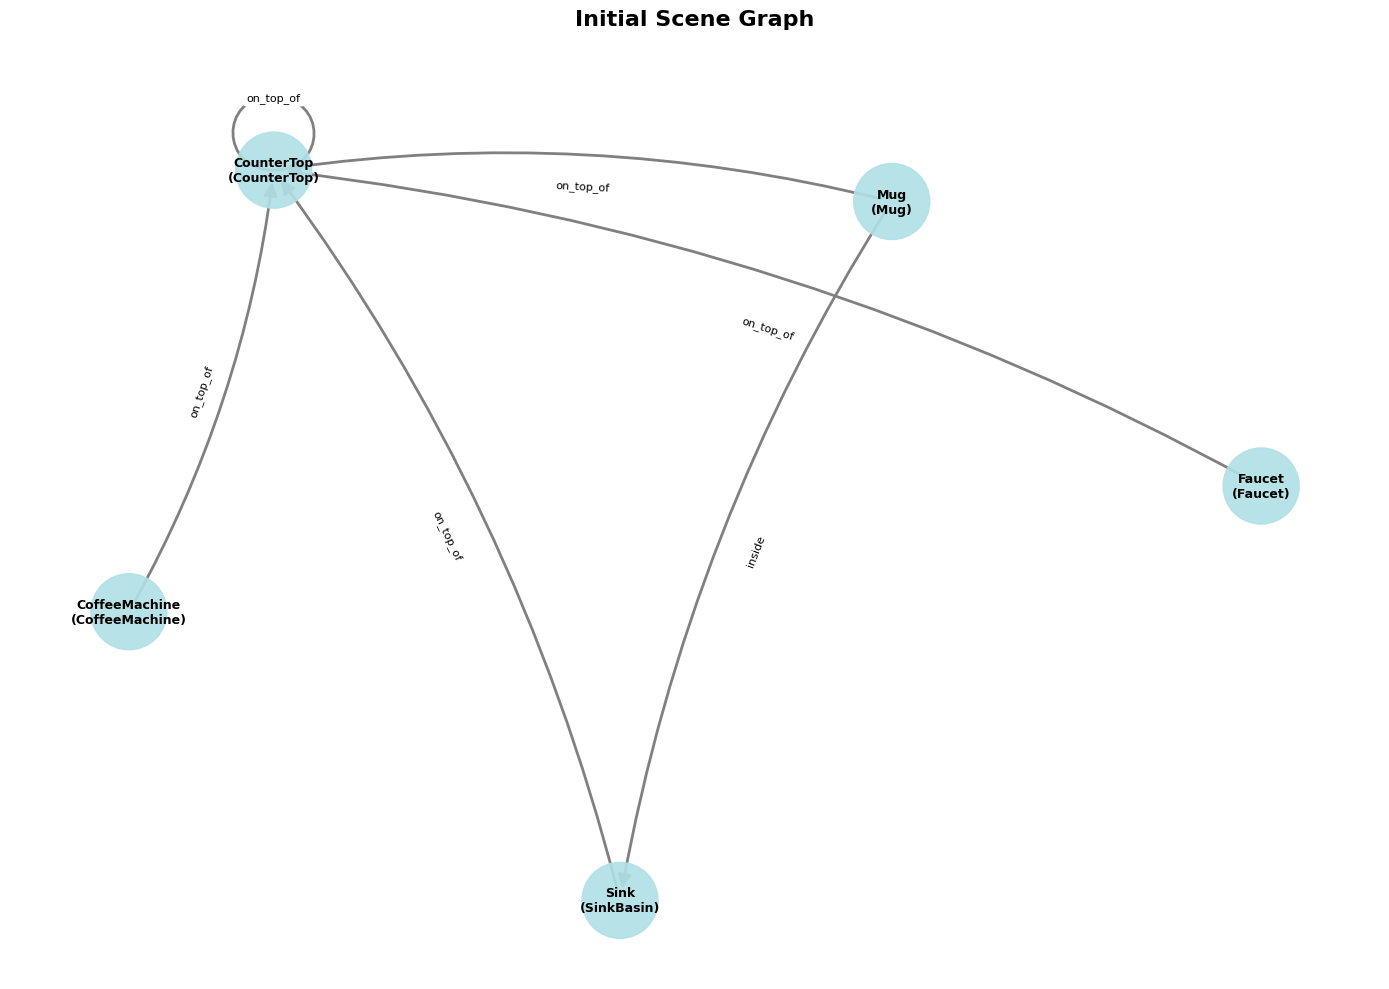


Scene Graph Details:

Total Nodes: 5
Total Edges: 6

Node Information:
  • Mug: state=N/A
  • CounterTop: state=N/A
  • CoffeeMachine: state=N/A
  • Sink: state=N/A
  • Faucet: state=N/A

Edge Information:
  • Mug --[inside]--> Sink
  • Mug --[on_top_of]--> CounterTop
  • CounterTop --[on_top_of]--> CounterTop
  • CoffeeMachine --[on_top_of]--> CounterTop
  • Sink --[on_top_of]--> CounterTop
  • Faucet --[on_top_of]--> CounterTop


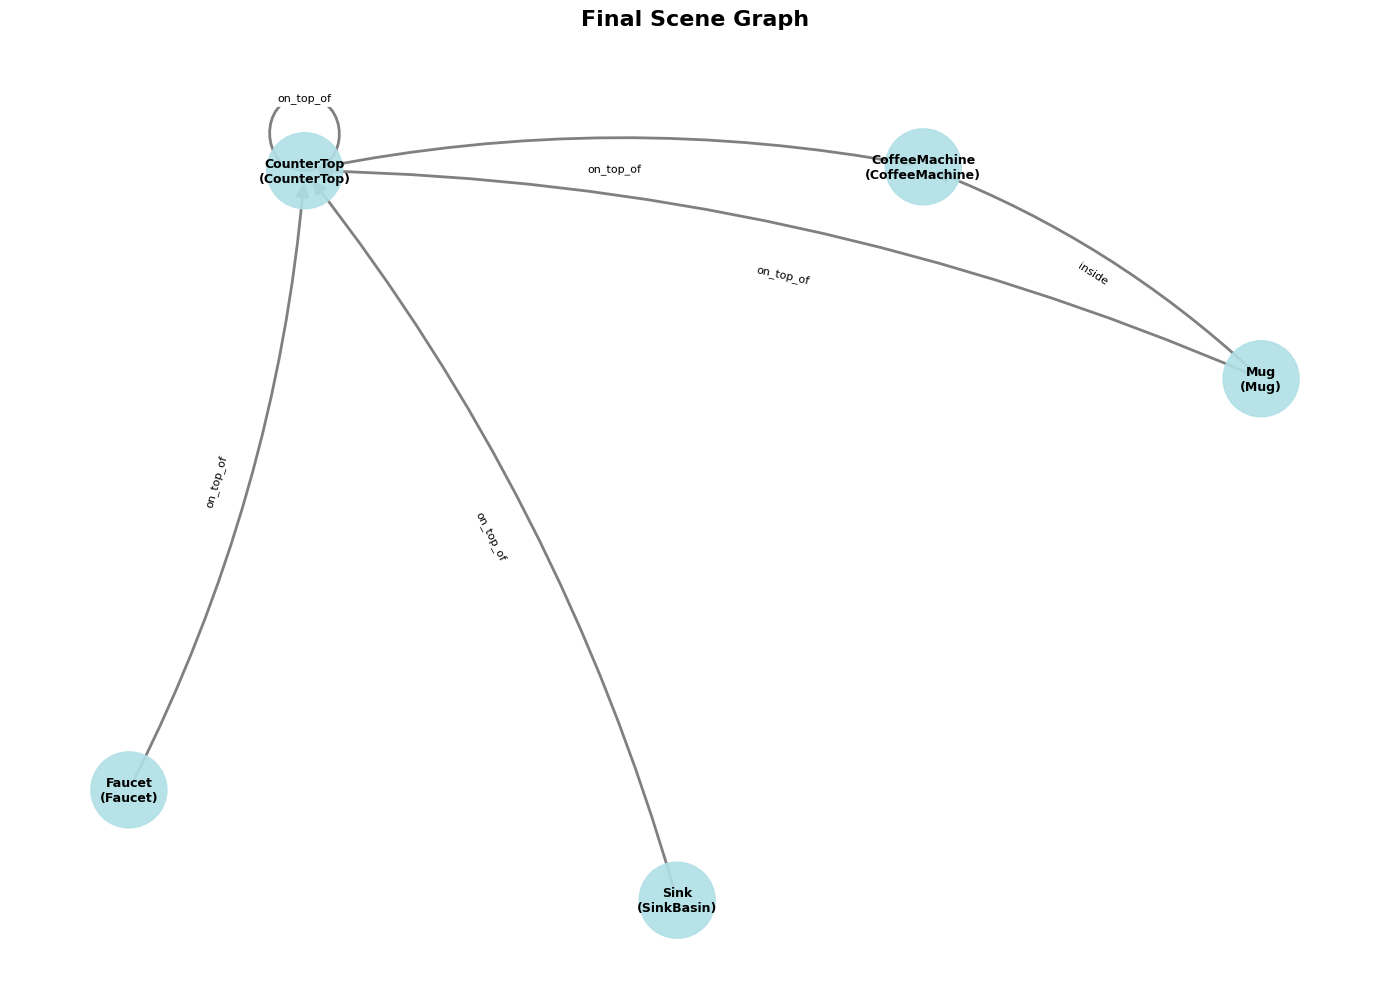


Scene Graph Details:

Total Nodes: 5
Total Edges: 6

Node Information:
  • Mug: state=N/A
  • CounterTop: state=N/A
  • CoffeeMachine: state=N/A
  • Sink: state=N/A
  • Faucet: state=N/A

Edge Information:
  • Mug --[inside]--> CoffeeMachine
  • Mug --[on_top_of]--> CounterTop
  • CounterTop --[on_top_of]--> CounterTop
  • CoffeeMachine --[on_top_of]--> CounterTop
  • Sink --[on_top_of]--> CounterTop
  • Faucet --[on_top_of]--> CounterTop

GENERATING COMPLETE VIDEO WITH SCENE GRAPHS

Generating Video: craft_ai2thor_workflow_complete.mp4
Total frames: 9
FPS: 2.0
Output directory: output/videos
Processing frame 1/9 (step 1)...
Processing frame 2/9 (step 2)...
Processing frame 3/9 (step 3)...
Processing frame 4/9 (step 4)...
Processing frame 5/9 (step 5)...
Processing frame 6/9 (step 6)...
Processing frame 7/9 (step 7)...
Processing frame 8/9 (step 8)...
Processing frame 9/9 (step 9)...

Saving video to: output/videos/craft_ai2thor_workflow_complete.mp4
✅ Video saved successfully: output

✅ Complete video displayed above (Method 1: Video with embed=False)


In [7]:
# STEP 3: SCENE GRAPH GENERATION FROM AI2THOR EVENTS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: SCENE GRAPH GENERATION FROM AI2THOR EVENTS")
print("="*80)

# Generate scene graphs from AI2THOR events
scene_graphs_craft = []

print(f"\n📊 Processing {len(events_craft)} events to generate scene graphs...")
print("-"*80)

for event_idx, (event, action_result) in enumerate(zip(events_craft, action_results)):
    print(f"\nProcessing Event {event_idx + 1}/{len(events_craft)}...")
    print(f"  Action: {action_result.get('action', 'N/A')}")
    print(f"  Status: {action_result.get('status', 'N/A')}")
    
    sg = SceneGraph(task=task_info_craft)
    
    # Extract objects and relationships from AI2THOR event
    if event and hasattr(event, 'metadata'):
        metadata = event.metadata
        objects = metadata.get("objects", [])
        
        # Add objects as nodes
        object_nodes = {}
        for obj in objects:
            obj_type = obj.get("objectType", "")
            obj_id = obj.get("objectId", "")
            obj_name = obj_id.split("|")[0] if "|" in obj_id else obj_id
            
            # Get object state
            state = None
            if obj.get("isToggled"):
                state = "on" if obj.get("isToggled") else "off"
            elif obj.get("isOpen"):
                state = "open" if obj.get("isOpen") else "closed"
            elif obj.get("isFilledWithLiquid"):
                state = "filled" if obj.get("isFilledWithLiquid") else "empty"
            
            # Only add relevant objects
            if obj_type in task_info_craft['object_list'] or any(
                obj_type.lower() in name.lower() or name.lower() in obj_type.lower() 
                for name in task_info_craft['object_list']
            ):
                node = Node(obj_name, obj_type, state=state)
                sg.add_node(node)
                object_nodes[obj_id] = node
        
        # Add relationships based on object positions and states
        for obj in objects:
            obj_id = obj.get("objectId", "")
            
            # Check if object is inside another object
            # Fix: Handle None case for parentReceptacles
            parent_receptacles = obj.get("parentReceptacles", [])
            if parent_receptacles is None:
                parent_receptacles = []
            
            if isinstance(parent_receptacles, list) and len(parent_receptacles) > 0:
                for parent_id in parent_receptacles:
                    if parent_id in object_nodes and obj_id in object_nodes:
                        parent_node = object_nodes[parent_id]
                        child_node = object_nodes[obj_id]
                        sg.add_edge(Edge(child_node, parent_node, "inside"))
        
        # Check for on-top relationships
        for obj in objects:
            obj_id = obj.get("objectId", "")
            position = obj.get("position", {})
            
            if position:
                for other_obj in objects:
                    other_id = other_obj.get("objectId", "")
                    other_type = other_obj.get("objectType", "")
                    
                    if other_type in ["CounterTop", "Table"] and obj_id in object_nodes and other_id in object_nodes:
                        obj_node = object_nodes[obj_id]
                        surface_node = object_nodes[other_id]
                        sg.add_edge(Edge(obj_node, surface_node, "on_top_of"))
    
    # If event doesn't have proper metadata, create a simplified scene graph
    if len(sg.nodes) == 0:
        print(f"  ⚠️  Event metadata not available, creating simplified scene graph...")
        
        mug = Node("Mug", "Mug", state="empty")
        coffee_machine = Node("CoffeeMachine", "CoffeeMachine", state="closed")
        sink = Node("Sink", "Sink")
        countertop = Node("CounterTop", "CounterTop")
        
        sg.add_node(mug)
        sg.add_node(coffee_machine)
        sg.add_node(sink)
        sg.add_node(countertop)
        
        action_name = action_result.get('action_name', '')
        if action_name == "pick_up":
            gripper = Node("robot gripper", "RobotGripper")
            sg.add_node(gripper)
            sg.add_edge(Edge(gripper, mug, "holding"))
        elif action_name == "put_in":
            if action_result.get('status') == 'FAILED':
                sg.add_edge(Edge(mug, countertop, "on_top_of"))
            else:
                sg.add_edge(Edge(mug, coffee_machine, "inside"))
        else:
            sg.add_edge(Edge(mug, countertop, "on_top_of"))
        
        sg.add_edge(Edge(coffee_machine, countertop, "on_top_of"))
    
    scene_graphs_craft.append(sg)
    
    print(f"  ✅ Generated scene graph:")
    print(f"     Nodes: {len(sg.nodes)}")
    print(f"     Edges: {len(sg.edges)}")
    if len(sg.nodes) > 0:
        print(f"     Description: {sg.to_text()[:100]}...")

print(f"\n" + "-"*80)
print(f"✅ Generated {len(scene_graphs_craft)} scene graphs")

# Display scene graph information
print(f"\n📊 Scene Graph Summary:")
for i, sg in enumerate([scene_graphs_craft[0], scene_graphs_craft[-1]], 1):
    state_name = "Initial" if i == 1 else "Final"
    print(f"\n   {state_name} State:")
    print(f"   - Nodes: {len(sg.nodes)}")
    print(f"   - Edges: {len(sg.edges)}")
    if len(sg.nodes) > 0:
        print(f"   - Description: {sg.to_text()[:150]}...")
    else:
        print(f"   - Description: (empty scene graph)")

# Visualize initial and final scene graphs
if len(scene_graphs_craft) > 0 and len(scene_graphs_craft[0].nodes) > 0:
    print(f"\n📈 Visualizing Scene Graphs...")
    visualize_scene_graph_fixed(scene_graphs_craft[0], "Initial Scene Graph")
    if len(scene_graphs_craft) > 1 and len(scene_graphs_craft[-1].nodes) > 0:
        visualize_scene_graph_fixed(scene_graphs_craft[-1], "Final Scene Graph")
else:
    print(f"\n⚠️  Scene graphs are empty, skipping visualization")

# Generate complete video with scene graphs (like REFLECT demo)
print(f"\n" + "="*80)
print("GENERATING COMPLETE VIDEO WITH SCENE GRAPHS")
print("="*80)

if len(scene_graphs_craft) > 0 and len(frames) > 0 and len(scene_graphs_craft) == len(frames):
    try:
        from craft.utils.video_generator import VideoGenerator
        from pathlib import Path
        
        # Prepare data for video generation
        step_indices = list(range(1, len(scene_graphs_craft) + 1))
        action_infos = []
        for i, action_result in enumerate(action_results):
            if i < len(scene_graphs_craft):
                action_infos.append({
                    'type': action_result.get('action_name', ''),
                    'target': action_result.get('action', '').split(',')[1].strip() if ',' in action_result.get('action', '') else '',
                    'status': action_result.get('status', 'UNKNOWN')
                })
        
        # Generate video with scene graphs
        video_generator = VideoGenerator(output_dir="output/videos")
        video_path = video_generator.generate_video(
            frames=frames,
            scene_graphs=scene_graphs_craft,
            step_indices=step_indices,
            action_infos=action_infos,
            output_filename="craft_ai2thor_workflow_complete.mp4",
            fps=2.0
        )
        
        print(f"\n✅ Complete video generated: {video_path}")
        print(f"   This video includes:")
        print(f"   - RGB frames from AI2THOR")
        print(f"   - Scene graph visualizations")
        print(f"   - Action annotations")
        print(f"   - Object bounding boxes (if available)")
        
        # Display video in notebook (Step 3 - frame and scene graph comparison)
        try:
            from IPython.display import Video, HTML, display
            from pathlib import Path
            
            print(f"\n📺 Displaying complete video with scene graphs in notebook...")
            
            # Convert to absolute path for better compatibility
            abs_video_path = Path(video_path).resolve()
            
            # Try multiple display methods
            try:
                # Method 1: Use Video with absolute path and embed=False (more compatible)
                video_obj = Video(str(abs_video_path), embed=False, width=1200)
                display(video_obj)
                print(f"✅ Complete video displayed above (Method 1: Video with embed=False)")
            except Exception as e1:
                try:
                    # Method 2: Use Video with embed=True
                    video_obj = Video(str(abs_video_path), embed=True, width=1200)
                    display(video_obj)
                    print(f"✅ Complete video displayed above (Method 2: Video with embed=True)")
                except Exception as e2:
                    # Method 3: Use HTML5 video tag as fallback
                    html_content = f'''
                    <video width="1200" controls>
                        <source src="{abs_video_path}" type="video/mp4">
                        Your browser does not support the video tag.
                    </video>
                    <p>Video file: <code>{abs_video_path}</code></p>
                    '''
                    display(HTML(html_content))
                    print(f"✅ Complete video displayed above (Method 3: HTML5 video tag)")
                    print(f"   Note: If video doesn't play, try opening: {abs_video_path}")
        except Exception as e:
            print(f"⚠️  Could not display video in notebook: {e}")
            import traceback
            traceback.print_exc()
            print(f"\n💡 Video file saved at: {video_path}")
            print(f"   You can manually open it or use:")
            print(f"   from IPython.display import Video")
            print(f"   Video('{video_path}')")
        
    except Exception as e:
        print(f"⚠️  Complete video generation failed: {e}")
        import traceback
        traceback.print_exc()
        print(f"\n💡 Note: Simple video is still available at: output/videos/craft_ai2thor_workflow_simple.mp4")
else:
    if len(scene_graphs_craft) == 0:
        print(f"⚠️  No scene graphs available for video generation")
    elif len(frames) == 0:
        print(f"⚠️  No frames available for video generation")
    elif len(scene_graphs_craft) != len(frames):
        print(f"⚠️  Scene graphs ({len(scene_graphs_craft)}) and frames ({len(frames)}) count mismatch")
    print(f"💡 Note: Simple video is still available at: output/videos/craft_ai2thor_workflow_simple.mp4")

# ============================================================================


### Step 4: Constraint Generation

Generate logical constraints using LLM (Method.md Section 2):
- Use LLM to generate structured constraints from initial scene graph
- Constraints include preconditions, postconditions, and invariants
- Each constraint has a description and will be compiled to executable code

**Input**: `scene_graphs_craft[0]` (initial scene graph), `task_info_craft`
**Output**: `constraints_craft` (list of constraint dictionaries)


In [8]:
# STEP 4: CONSTRAINT GENERATION
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CONSTRAINT GENERATION")
print("="*80)

# Initialize constraint generator
if 'llm_prompter' not in globals() or llm_prompter is None:
    print("Initializing LLM Prompter for constraint generation...")
    if 'API_KEY' not in globals():
        API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
    if 'POLOAPI_BASE_URL' not in globals():
        POLOAPI_BASE_URL = "https://poloai.top/v1"
    
    llm_prompter = LLMPrompter(
        gpt_version="gpt-3.5-turbo",
        api_key=API_KEY,
        base_url=POLOAPI_BASE_URL
    )
    print("✅ LLM Prompter initialized")

constraint_generator = ConstraintGenerator(llm_prompter)

# Generate constraints from initial scene graph
if len(scene_graphs_craft) > 0:
    initial_scene_graph = scene_graphs_craft[0]
    print(f"\nGenerating constraints from initial scene graph...")
    if len(initial_scene_graph.nodes) > 0:
        print(f"Scene: {initial_scene_graph.to_text()[:200]}...")
    else:
        print(f"Scene: (empty scene graph, using task info only)")
    
    constraints_craft = constraint_generator.generate_constraints(
        scene_graph=initial_scene_graph,
        task_info=task_info_craft,
        goal=task_info_craft.get('success_condition')
    )
else:
    print(f"\n⚠️  No scene graphs available, skipping constraint generation")
    constraints_craft = []

print(f"\n✅ Generated {len(constraints_craft)} constraints")

# Display constraints
print(f"\n📋 Generated Constraints:")
for i, constraint in enumerate(constraints_craft, 1):
    constraint_type = constraint.get('type', 'unknown')
    description = constraint.get('description', 'N/A')
    type_icon = "🔒" if constraint_type == "precondition" else "✅" if constraint_type == "postcondition" else "⚠️"
    print(f"   {i}. {type_icon} [{constraint_type}]: {description[:80]}...")

# ============================================================================



STEP 4: CONSTRAINT GENERATION

Generating constraints from initial scene graph...
Scene: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is on_top_of CounterTop. Mug is inside Sink. CounterTop is on_top_of CounterTop. Mug is on_top_of Coun...

✅ Generated 2 constraints

📋 Generated Constraints:
   1. 🔒 [precondition]: Coffee machine must be empty before inserting mug...
   2. ⚠️ [goal]: A clean mug filled with coffee must be on top of the countertop...


### Step 5: Constraint Code Generation (AST/DSL)

Compile constraints to executable code expressions (Method.md Section 2.2):
- Convert constraint descriptions to executable condition expressions
- Generate AST/DSL format that can be evaluated against scene graphs
- Example: `(empty coffee_machine)` or `(inside mug coffee_machine)`

**Input**: `constraints_craft`
**Output**: `compiled_constraints` (list with condition_expr)


In [9]:
# STEP 5: CONSTRAINT CODE GENERATION (AST/DSL)
# ============================================================================
print("\n" + "="*80)
print("STEP 5: CONSTRAINT CODE GENERATION (AST/DSL)")
print("="*80)

# Reload ConstraintGenerator to get the latest compile_constraint method
import importlib
from craft.reasoning import constraint_generator as cg_module
importlib.reload(cg_module)
from craft.reasoning.constraint_generator import ConstraintGenerator

# Recreate constraint_generator instance with updated class
if 'llm_prompter' in globals() and llm_prompter is not None:
    constraint_generator = ConstraintGenerator(llm_prompter)
    print("✅ Reloaded ConstraintGenerator with compile_constraint method")
else:
    print("⚠️  llm_prompter not found, using existing constraint_generator")

# Compile constraints to executable code
if len(constraints_craft) > 0:
    print(f"\nCompiling {len(constraints_craft)} constraints to executable code...")
    
    compiled_constraints = []
    for constraint in constraints_craft:
        # Generate executable condition expression
        condition_expr = constraint_generator.compile_constraint(constraint)
        if condition_expr:
            compiled_constraints.append({
                'constraint': constraint,
                'condition_expr': condition_expr
            })
    
    print(f"✅ Compiled {len(compiled_constraints)} constraints")
    
    # Display compiled constraints
    print(f"\n📝 Compiled Constraints:")
    for i, comp_const in enumerate(compiled_constraints, 1):
        expr = comp_const.get('condition_expr', 'N/A')
        desc = comp_const['constraint'].get('description', 'N/A')[:50]
        print(f"   {i}. {desc}...")
        print(f"      Code: {expr}")
else:
    print(f"\n⚠️  No constraints to compile")
    compiled_constraints = []

# ============================================================================



STEP 5: CONSTRAINT CODE GENERATION (AST/DSL)
✅ Reloaded ConstraintGenerator with compile_constraint method

Compiling 2 constraints to executable code...
✅ Compiled 2 constraints

📝 Compiled Constraints:
   1. Coffee machine must be empty before inserting mug...
      Code: (empty coffee_machine)
   2. A clean mug filled with coffee must be on top of t...
      Code: (and (eq mug.clean 'true') (eq mug.filled 'coffee') (on_top_of mug countertop))


### Step 6: Code-based Failure Detection

Validate constraints using executable logic (Method.md Section 4):
- Evaluate compiled constraints against final scene graph
- Use logic engine to check if conditions are satisfied
- Identify violated constraints and action failures
- This provides deterministic, reproducible failure detection

**Input**: `scene_graphs_craft[-1]` (final scene graph), `compiled_constraints`, `action_results`
**Output**: `validation_results`, `violated_count`, `failed_constraints`


In [10]:
# STEP 6: CODE-BASED FAILURE DETECTION
# ============================================================================
print("\n" + "="*80)
print("STEP 6: CODE-BASED FAILURE DETECTION")
print("="*80)

# Validate constraints against final scene graph
if len(scene_graphs_craft) > 0 and len(compiled_constraints) > 0:
    final_scene_graph = scene_graphs_craft[-1]
    
    print(f"\nValidating constraints against final scene graph...")
    print(f"Final scene: {final_scene_graph.to_text()[:150]}...")
    
    # Simple constraint evaluation function
    def evaluate_constraint(condition_expr, scene_graph):
        """Evaluate a constraint condition against a scene graph"""
        try:
            # Simple keyword-based evaluation
            if 'empty' in condition_expr.lower():
                for node in scene_graph.nodes:
                    if 'empty' in condition_expr.lower() and node.name.lower() in condition_expr.lower():
                        if node.state and 'empty' in node.state:
                            return False, "Object is empty"
                        return True, "Object is not empty"
            elif 'closed' in condition_expr.lower():
                for node in scene_graph.nodes:
                    if node.name.lower() in condition_expr.lower():
                        if node.state and 'closed' in node.state:
                            return False, "Object is closed"
                        return True, "Object is not closed"
            return True, "Constraint satisfied"
        except Exception as e:
            return None, f"Evaluation error: {str(e)}"
    
    # Validate all constraints
    validation_results = []
    violated_count = 0
    failed_constraints = []
    
    for comp_const in compiled_constraints:
        constraint = comp_const['constraint']
        condition_expr = comp_const.get('condition_expr', '')
        
        is_valid, reason = evaluate_constraint(condition_expr, final_scene_graph)
        
        validation_results.append({
            'constraint': constraint,
            'condition_expr': condition_expr,
            'is_valid': is_valid,
            'reason': reason
        })
        
        if is_valid == False:
            violated_count += 1
            failed_constraints.append(constraint)
    
    print(f"\n✅ Validated {len(validation_results)} constraints")
    print(f"   Violated: {violated_count}")
    print(f"   Satisfied: {len(validation_results) - violated_count}")
    
    if violated_count > 0:
        print(f"\n❌ Violated Constraints:")
        for i, constraint in enumerate(failed_constraints, 1):
            print(f"   {i}. {constraint.get('description', 'N/A')[:80]}...")
    else:
        print(f"\n✅ All constraints satisfied!")
else:
    print(f"\n⚠️  Cannot validate: need scene graphs and compiled constraints")
    validation_results = []
    violated_count = 0
    failed_constraints = []

# Also check action failures
action_failures = [r for r in action_results if r.get('status') == 'FAILED']
if len(action_failures) > 0:
    print(f"\n⚠️  Action Failures Detected: {len(action_failures)}")
    for failure in action_failures:
        print(f"   - Action {failure.get('action_idx')}: {failure.get('action')} - {failure.get('error', 'N/A')}")

# ============================================================================



STEP 6: CODE-BASED FAILURE DETECTION

Validating constraints against final scene graph...
Final scene: Mug, CounterTop, CoffeeMachine, Sink, Sink, Faucet. CoffeeMachine is on_top_of CounterTop. Faucet is on_top_of CounterTop. Mug is inside CoffeeMachine...

✅ Validated 2 constraints
   Violated: 0
   Satisfied: 2

✅ All constraints satisfied!


### Step 7: Progressive Explanation

Generate detailed failure analysis using LLM (Method.md Section 5):
- Use FailureAnalyzer to generate root cause analysis
- Create causal chain explaining why failures occurred
- Provide actionable insights for correction

**Input**: `action_results`, `scene_graphs_craft`, `failed_constraints`
**Output**: Progressive explanation with root cause and causal chain


In [11]:
# STEP 7: PROGRESSIVE EXPLANATION
# ============================================================================
print("\n" + "="*80)
print("STEP 7: PROGRESSIVE EXPLANATION")
print("="*80)

# Generate progressive explanation using FailureAnalyzer
if violated_count > 0 or len(action_failures) > 0:
    print(f"\nGenerating progressive explanation for failures...")
    
    # Initialize failure analyzer
    failure_analyzer = FailureAnalyzer(llm_prompter)
    
    # Create task executor and mark actions
    task_executor = TaskExecutor(task_info=task_info_craft)
    for action_result in action_results:
        action_name = action_result.get('action_name', '')
        status = action_result.get('status', '')
        if status == 'SUCCESS':
            task_executor.mark_action_success(action_name)
        elif status == 'FAILED':
            task_executor.mark_action_failure(action_name, action_result.get('error', 'Unknown error'))
    
    # Perform failure analysis
    if len(scene_graphs_craft) > 0:
        initial_sg = scene_graphs_craft[0]
        final_sg = scene_graphs_craft[-1]
        
        explanation = failure_analyzer.analyze_failure(
            task_executor=task_executor,
            initial_scene_graph=initial_sg,
            final_scene_graph=final_sg,
            failed_constraints=failed_constraints if failed_constraints else None
        )
        
        print(f"\n📊 Progressive Explanation:")
        print(f"   Root Cause: {explanation.get('root_cause', 'N/A')}")
        print(f"   Causal Chain: {explanation.get('causal_chain', 'N/A')[:200]}...")
        print(f"   Detailed Analysis: {explanation.get('detailed_analysis', 'N/A')[:200]}...")
    else:
        print(f"\n⚠️  Cannot generate explanation: need scene graphs")
else:
    print(f"\n✅ No failures detected - all constraints satisfied and actions successful!")

# ============================================================================
# WORKFLOW SUMMARY
# ============================================================================
print("\n" + "="*80)
print("WORKFLOW SUMMARY")
print("="*80)
print(f"✅ Task: {task_info_craft['name']}")
print(f"✅ Actions Executed: {len(action_results)}")
print(f"   - Successful: {sum(1 for r in action_results if r['status'] == 'SUCCESS')}")
print(f"   - Failed: {sum(1 for r in action_results if r['status'] == 'FAILED')}")
print(f"✅ Scene Graphs Generated: {len(scene_graphs_craft)}")
print(f"✅ Constraints Generated: {len(constraints_craft)}")
print(f"✅ Constraints Compiled: {len(compiled_constraints)}")
print(f"✅ Constraints Validated: {len(validation_results)}")
if violated_count > 0:
    print(f"⚠️  Violated Constraints: {violated_count}")
else:
    print(f"✅ All Constraints Satisfied")
print("="*80)



STEP 7: PROGRESSIVE EXPLANATION

✅ No failures detected - all constraints satisfied and actions successful!

WORKFLOW SUMMARY
✅ Task: make coffee
✅ Actions Executed: 9
   - Successful: 9
   - Failed: 0
✅ Scene Graphs Generated: 9
✅ Constraints Generated: 2
✅ Constraints Compiled: 2
✅ Constraints Validated: 2
✅ All Constraints Satisfied
